# Lab | Random Forests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
targets = pd.read_csv('./files_for_lab/target.csv')
categorical = pd.read_csv('./files_for_lab/categorical.csv')
numerical = pd.read_csv('./files_for_lab/numerical.csv')

In [3]:
print(targets.shape)
print(categorical.shape)
print(numerical.shape)

(95412, 2)
(95412, 22)
(95412, 315)


In [4]:
print(targets.isna().sum().sum())
print(categorical.isna().sum().sum())
print(numerical.isna().sum().sum())

0
0
0


In [5]:
# targets

In [6]:
categorical

,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM
0,IL,36,H,F,3,L,E,C,T,2,89,1,37,12,92,8,94,2,95,12,89,11
1,CA,14,H,M,3,L,G,A,S,1,94,1,52,2,93,10,95,12,95,12,93,10
2,NC,43,U,M,3,L,E,C,R,2,90,1,0,2,91,11,92,7,95,12,90,1
3,CA,44,U,F,3,L,E,C,R,2,87,1,28,1,87,11,94,11,95,12,87,2
4,FL,16,H,F,3,L,F,A,S,2,86,1,20,1,93,10,96,1,96,1,79,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,other,27,H,M,3,L,G,C,C,2,96,1,0,2,96,2,96,2,96,2,96,2
95408,TX,24,H,M,3,L,F,A,C,1,96,1,50,1,96,3,96,3,96,3,96,3
95409,MI,30,H,M,3,L,E,B,C,3,95,1,38,1,96,3,95,1,96,10,94,10
95410,CA,24,H,F,2,L,F,A,C,1,86,1,40,5,90,11,96,8,97,1,86,12


In [7]:
numerical

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2
0,0,60.000000,5,9,0,0,39,34,18,10,2,1,5,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,27,74,6,14,240.0,31,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39
1,1,46.000000,6,9,16,0,15,55,11,6,2,1,9,3611,940,998,99,0,0,50,50,67,0,0,31,6,4,2,6,4,14,0,0,2,0,1,4,34,41,43,32,42,45,32,33,46,21,13,14,33,23,10,4,2,11,16,36,22,15,12,1,5,4,21,75,55,23,9,69,4,3,24,317,360,99,99,0,0,0,0,0,0,0,5468,5218,12,10,96,4,97,3,9,59,94,88,55,95,5,4,1,3,5,4,2,18,44,5,0,0,0,97,98,98,98,99,94,0,83,76,73,21,5,0,0,0,4,0,0,0,91,91,91,94,4480.0,13.0,803.0,1088,1096,1026,1037,36175,2,6,2,5,15,14,13,10,33,2,5,2,5,15,14,14,10,32,6,2,66,3,56,44,9,80,14,0,0,0,0,0,0,6,0,2,24,32,12,71,70,83,58,81,57,64,57,99,99,0,22,24,4,21,13,2,1,6,0,4,1,0,3,1,0,6,13,1,2,8,18,11,4,3,4,10,7,11,1,6,2,1,16,69,5,2,160,5,5,12,21,7,30,20,14,24,4,24,10,0,0,0,8,15,0,55,10,11,0,0,2,0,3,1,1,2,3,1,1,0,3,0,0,0,42,39,50,7,27,16,99,92,53,5,10,2,26,56,97,99,0,0,0,96,0,4,0,0,0,99,0,99,99,99,20,4,6,5,12,32,6,13,47.0,3,1,10.0,25.0,25.0,18,15.666667,148535,0,2,1
2,1,61.611649,3,1,2,0,20,29,33,6,8,1,1,7001,2040,2669,0,2,98,49,51,96,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,35,43,46,37,45,49,23,35,40,25,13,20,19,16,13,10,8,15,14,30,22,19,25,10,23,21,35,44,22,6,2,63,9,9,19,183,254,69,69,1,6,5,3,3,3,0,497,546,2,1,78,22,93,7,18,36,76,65,30,86,14,7,2,5,11,17,3,17,60,18,0,1,0,0,1,6,18,50,0,4,36,49,51,14,5,4,2,24,11,2,3,6,0,2,9,44,0.0,281.0,518.0,251,292,292,340,11576,32,18,20,15,12,2,0,0,1,20,19,24,18,16,2,0,0,1,28,8,31,11,38,62,8,74,22,0,0,0,0,0,2,2,1,21,19,24,6,61,65,73,59,70,56,78,62,82,99,4,10,5,2,6,12,0,1,9,5,18,20,5,7,6,0,11,33,4,3,2,12,3,3

We drop DOB as we already have the AGE.

In [8]:
categorical = categorical.drop('DOB_YR', axis=1).drop('DOB_MM', axis=1)

We drop TCODE, DOB, ADI, DMA, MSA and CONTROLN (it is a unique record identifier).

In [9]:
numerical = numerical.drop(['TCODE', 'ADI', 'DMA', 'MSA', 'CONTROLN'], axis=1)

RFA_2F, CLUSTER2 will be included as categorical.

In [10]:
categorical['RFA_2F'] = numerical['RFA_2F']

In [11]:
categorical['CLUSTER2'] = numerical['CLUSTER2']

In [12]:
numerical = numerical.drop(['RFA_2F', 'CLUSTER2'], axis=1)

In [13]:
categorical['RFA_2F'] = categorical['RFA_2F'].astype(str)
categorical['CLUSTER'] = categorical['CLUSTER'].astype(str)
categorical['CLUSTER2'] = categorical['CLUSTER2'].astype(str)
categorical['DATSRCE'] = categorical['DATASRCE'].astype(str)

Income, wealth1 and wealth2 are categories but can be treated with the scaler as numerical.

In [14]:
# categorical = categorical.astype(str)

### Train-test split.

In [15]:
X = pd.concat([categorical, numerical], axis=1)

In [16]:
X.shape

(95412, 331)

In [17]:
y = targets.drop('TARGET_D', axis=1)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Oversampling.

In [19]:
df_train = pd.concat([X_train, y_train], axis=1)

In [20]:
df_train_1 = df_train[df_train['TARGET_B']==1]
df_train_0 = df_train[df_train['TARGET_B']==0]

In [21]:
print(len(df_train_1))
len(df_train_0)

3600


67959

In [22]:
from sklearn.utils import resample
df_train_1_ov = resample(df_train_1, replace=True, n_samples = len(df_train_0))

In [23]:
print(len(df_train_1_ov))
len(df_train_0)

67959


67959

In [24]:
df_train_ov = pd.concat([df_train_1_ov, df_train_0], axis=0).reset_index(drop=True)

In [25]:
X_train_ov = df_train_ov.drop('TARGET_B', axis=1)
y_train_ov = df_train_ov['TARGET_B']

In [26]:
X_train_ov.isna().sum().sum()

0

In [27]:
y_train_ov.isna().sum().sum()

0

### Encoding.

Train.

In [28]:
X_train_ov_num = X_train_ov.select_dtypes(exclude=object)
X_train_ov_cat = X_train_ov.select_dtypes(include=object)

In [29]:
# X_train_ov_num

In [30]:
# X_train_ov_cat

In [31]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first', handle_unknown='ignore').fit(X_train_ov_cat)

In [32]:
X_train_cat_encoded = encoder.transform(X_train_ov_cat).toarray()

In [33]:
feature_names = encoder.get_feature_names_out(input_features=X_train_ov_cat.columns)

X_train_cat_enc = pd.DataFrame(X_train_cat_encoded, columns=feature_names)

In [34]:
# X_train_cat_enc

Test.

In [35]:
X_test_num = X_test.select_dtypes(exclude=object)
X_test_cat = X_test.select_dtypes(include=object)

In [36]:
X_test_cat_encoded = encoder.transform(X_test_cat).toarray()

In [37]:
feature_names = encoder.get_feature_names_out(input_features=X_test_cat.columns)

X_test_cat_enc = pd.DataFrame(X_test_cat_encoded, columns=feature_names)

In [38]:
# X_test_cat_enc

### Scaling.

Train.

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()

In [40]:
scaler.fit(X_train_ov_num)

MinMaxScaler()

In [41]:
X_train_num_sc = pd.DataFrame(scaler.transform(X_train_ov_num), columns=X_train_ov_num.columns)

In [42]:
# X_train_num_sc

Test.

In [43]:
X_test_num_sc = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

In [44]:
# X_test_num_sc

### Concat.

In [45]:
X_train_tr = pd.concat([X_train_num_sc, X_train_cat_enc], axis=1)

In [46]:
X_train_tr.isna().sum().sum()

0

In [47]:
X_test_tr = pd.concat([X_test_num_sc, X_test_cat_enc], axis=1)

In [48]:
X_test_tr.isna().sum().sum()

0

In [49]:
df_train_tr = pd.concat([X_train_tr, y_train_ov], axis=1)

In [50]:
df_train_tr.isna().sum().sum()

0

In [51]:
y_test = y_test.reset_index(drop=True)

In [52]:
df_test_tr = pd.concat([X_test_tr, y_test], axis=1)

In [53]:
df_test_tr.isna().sum().sum()

0

### Random forest (1).

In [54]:
X_train = df_train_tr.drop('TARGET_B', axis=1)
y_train = df_train_tr['TARGET_B']

In [55]:
X_test = df_test_tr.drop('TARGET_B', axis=1)
y_test = df_test_tr['TARGET_B']

In [56]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(max_depth=5,
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8,
                             )
rf1.fit(X_train, y_train)
print(rf1.score(X_train, y_train))
print(rf1.score(X_test, y_test))

0.6220000294295089
0.6069257535739739


In [57]:
from sklearn.metrics import confusion_matrix
y_pred = rf1.predict(X_test)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0    22610
1     1243
Name: TARGET_B, dtype: int64

array([[13808,  8802],
       [  574,   669]], dtype=int64)

In [58]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("precision: ",precision_score(y_test,y_pred))
print("recall: ",recall_score(y_test,y_pred))
print("f1: ",f1_score(y_test,y_pred))

precision:  0.07063668039277796
recall:  0.5382139983909895
f1:  0.12488333022213927


### Feature selection (variance).

In [59]:
from sklearn.feature_selection import VarianceThreshold
var_threshold = 0.02
sel = VarianceThreshold(threshold=(var_threshold))

sel = sel.fit(X_train)

sel.get_support()
var_list=list(sel.get_support())
droplist_var=[col[0] for col in zip(X_train.columns, var_list) if col[1] == False]
# print(droplist_var)
len(droplist_var)

321

In [60]:
X_train_2 = X_train.drop(droplist_var, axis=1)
X_test_2 = X_test.drop(droplist_var, axis=1)

In [61]:
# droplist = pd.DataFrame({'columns': droplist_var})
# droplist.to_csv('droplist_var.csv', index=False)

### Random forest (2).

In [62]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(max_depth=5,
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8,
                             )
rf2.fit(X_train_2, y_train)
print(rf2.score(X_train_2, y_train))
print(rf2.score(X_test_2, y_test))

0.6214187966273783
0.6019368632876367


In [63]:
from sklearn.metrics import confusion_matrix
y_pred_2 = rf2.predict(X_test_2)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred_2))

0    22610
1     1243
Name: TARGET_B, dtype: int64

array([[13706,  8904],
       [  591,   652]], dtype=int64)

In [64]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("precision: ",precision_score(y_test,y_pred_2))
print("recall: ",recall_score(y_test,y_pred_2))
print("f1: ",f1_score(y_test,y_pred_2))

precision:  0.06822938467978233
recall:  0.5245374094931617
f1:  0.12075192147421056


### Feature selection (Selectkbest).

In [65]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
kbest = SelectKBest(chi2, k=10).fit(X_train_2, y_train)

In [66]:
df =pd.DataFrame(data = kbest.scores_, columns = ['score'])
df['Column'] = X_train_2.columns
# print(df.sort_values(by = ['score'], ascending = False))

In [67]:
cols = df.sort_values(by = ['score'], ascending = False).head(30)['Column']
type(cols)

pandas.core.series.Series

In [68]:
cols

125       RFA_2F_4
115       RFA_2A_G
113       RFA_2A_E
124       RFA_2F_3
114       RFA_2A_F
5      LASTDATE_YR
35            HVP2
34            HVP1
18            ETH2
36            HVP3
39            HVP6
37            HVP4
104     CLUSTER_40
93      CLUSTER_13
127    CLUSTER2_12
44             RP1
45             RP2
2        ODATEW_YR
1         DOMAIN_B
6      LASTDATE_MM
25             HV1
26             HV2
81        STATE_GA
139      DATSRCE_2
128    CLUSTER2_13
78        CARDPROM
107     CLUSTER_46
38            HVP5
110     HOMEOWNR_U
100     CLUSTER_30
Name: Column, dtype: object

In [69]:
cols.to_csv('final_cols.csv', index=False)

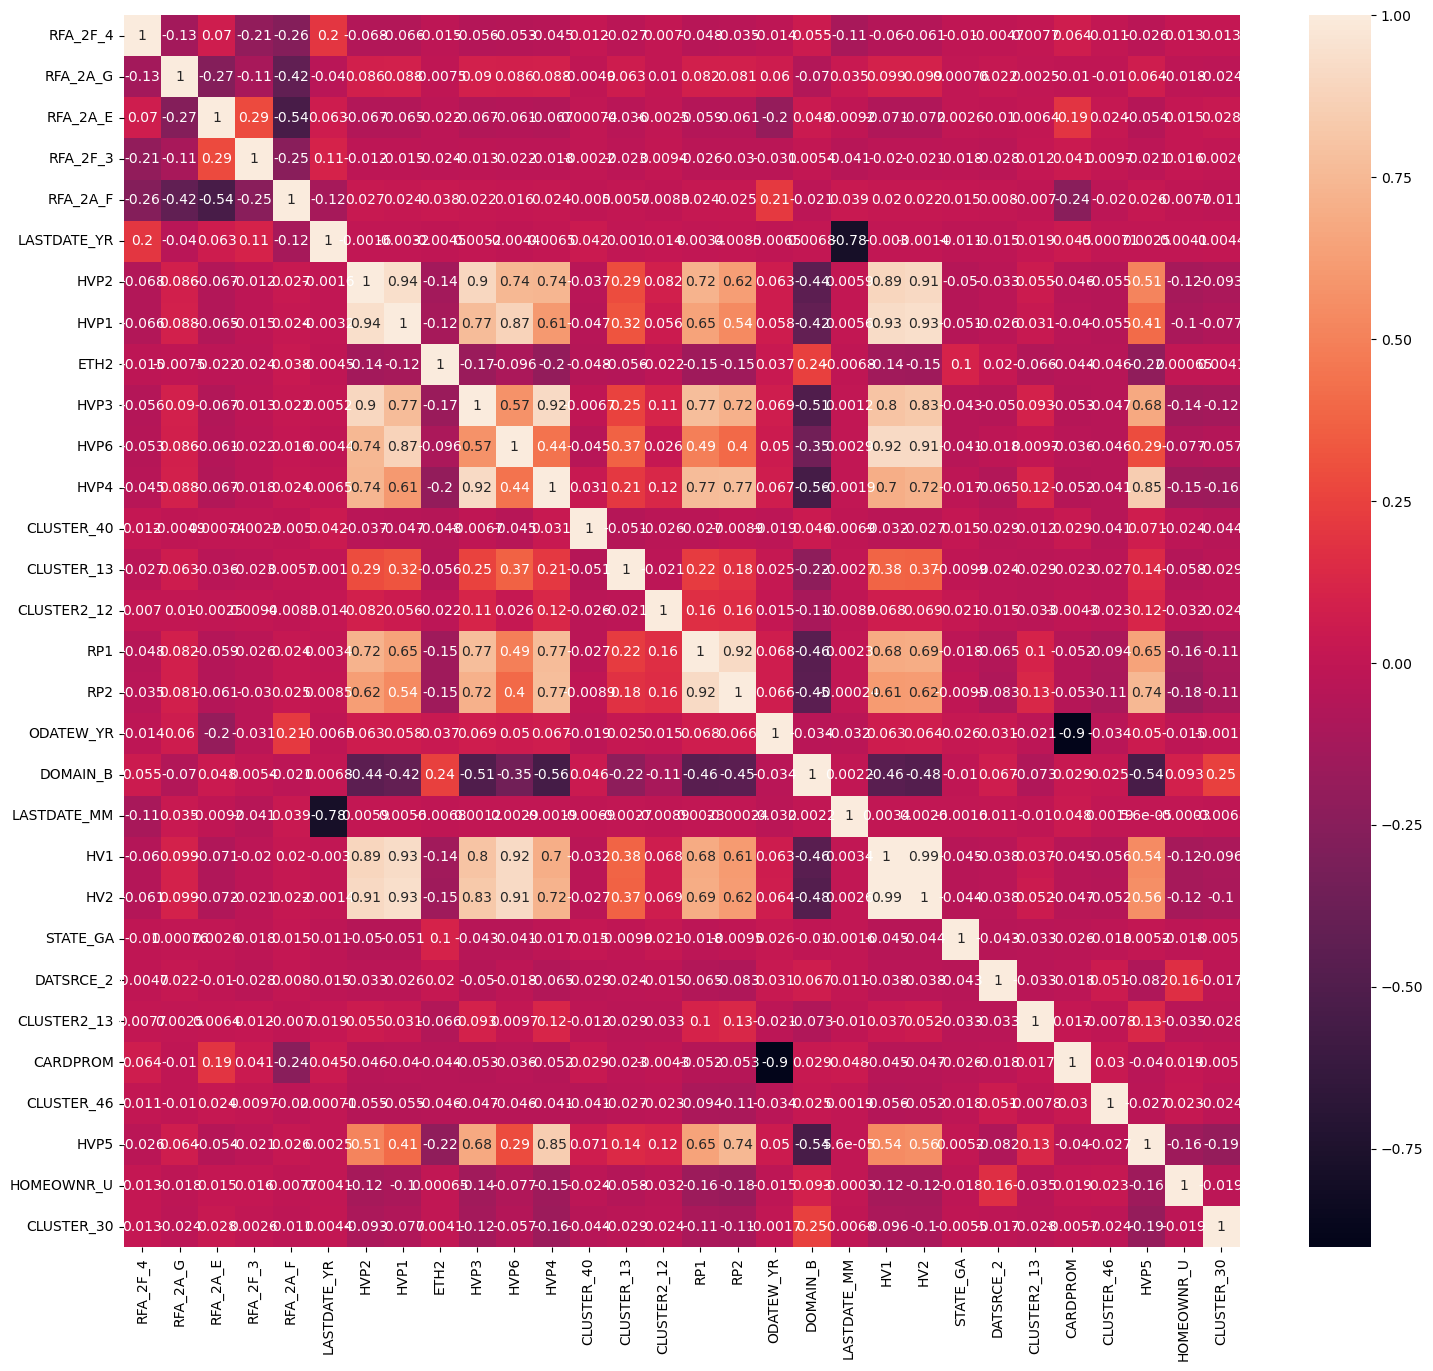

In [70]:
corr_matrix=X_train_2[cols].corr()
fig, ax = plt.subplots(figsize=(18,16))
ax = sns.heatmap(corr_matrix, annot=True)

In [71]:
X_train_3 = X_train_2[cols]
X_test_3 = X_test_2[cols]

### Random forest (3).

In [72]:
from sklearn.ensemble import RandomForestClassifier
rf3 = RandomForestClassifier(max_depth=5,
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8,
                             )
rf3.fit(X_train_3, y_train)
print(rf3.score(X_train_3, y_train))
print(rf3.score(X_test_3, y_test))

0.6025324092467517
0.6060453611705027


In [73]:
from sklearn.metrics import confusion_matrix
y_pred_3 = rf3.predict(X_test_3)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred_3))

0    22610
1     1243
Name: TARGET_B, dtype: int64

array([[13825,  8785],
       [  612,   631]], dtype=int64)

In [74]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("precision: ",precision_score(y_test,y_pred_3))
print("recall: ",recall_score(y_test,y_pred_3))
print("f1: ",f1_score(y_test,y_pred_3))

precision:  0.06701359388275276
recall:  0.5076427996781979
f1:  0.11839759827375926


Discuss the output and its impact in the business scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the business?

All three models offer a similar f1 score (which takes into acocunt both precision and recall). In this case, we are interested in both metrics, but particularly in recall, as we want to be able to identify as many actual donors as possible.

### Predicting with original data.

In [75]:
X = pd.concat([categorical, numerical], axis=1)

In [76]:
X.isna().sum().sum()

0

In [77]:
y = targets.drop('TARGET_D', axis=1)

In [78]:
y.isna().sum().sum()

0

In [79]:
X_cat = X.select_dtypes(include=object)
X_num = X.select_dtypes(exclude=object)

Encoding.

In [80]:
X_cat_encoded = encoder.transform(X_cat).toarray()
feature_names = encoder.get_feature_names_out(input_features=X_cat.columns)
X_cat_enc = pd.DataFrame(X_cat_encoded, index=X_cat.index, columns=feature_names)

Scaling.

In [81]:
X_num_sc = pd.DataFrame(scaler.transform(X_num), index=X_num.index, columns=X_num.columns)

Concat.

In [82]:
X_tr = pd.concat([X_num_sc, X_cat_enc], axis=1)
X_tr.isna().sum().sum()

0

In [83]:
df_tr = pd.concat([X_tr, y], axis=1)
df_tr.isna().sum().sum()

0

Dropping features.

In [84]:
X_tr = X_tr[cols]

In [85]:
y_pred_4 = rf3.predict(X_tr)
display(y.value_counts())
display(confusion_matrix(y, y_pred_4))

TARGET_B
0           90569
1            4843
dtype: int64

array([[56052, 34517],
       [ 2120,  2723]], dtype=int64)

In [86]:
print("precision: ",precision_score(y, y_pred_4))
print("recall: ",recall_score(y, y_pred_4))
print("f1: ",f1_score(y, y_pred_4))

precision:  0.0731203007518797
recall:  0.5622548007433409
f1:  0.12941092602713683


In [87]:
predB = pd.Series(y_pred_4)
predB.name = 'PRED_B'

Concat.

In [88]:
df_predB = pd.concat([X, y, predB, targets['TARGET_D']], axis=1)
df_predB.isna().sum().sum()

0

In [93]:
df_predB.to_csv('df_predB.csv')

In [90]:
df_tr_predB = pd.concat([X_tr, y, predB,  targets['TARGET_D']], axis=1)
df_tr_predB.isna().sum().sum()

0

In [91]:
# df_tr_predB

In [92]:
# df_tr_predB.to_csv('df_tr_predB.csv')